In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [ ]:
# Load train and Test set
train = pd.read_csv("TrainingData.csv",encoding='iso-8859-1')
test = pd.read_csv("TestData.csv")

In [ ]:
# Drop rows which will be used for test in the training set
train = train[train['predict'] == 0]

# Reduce redundancy

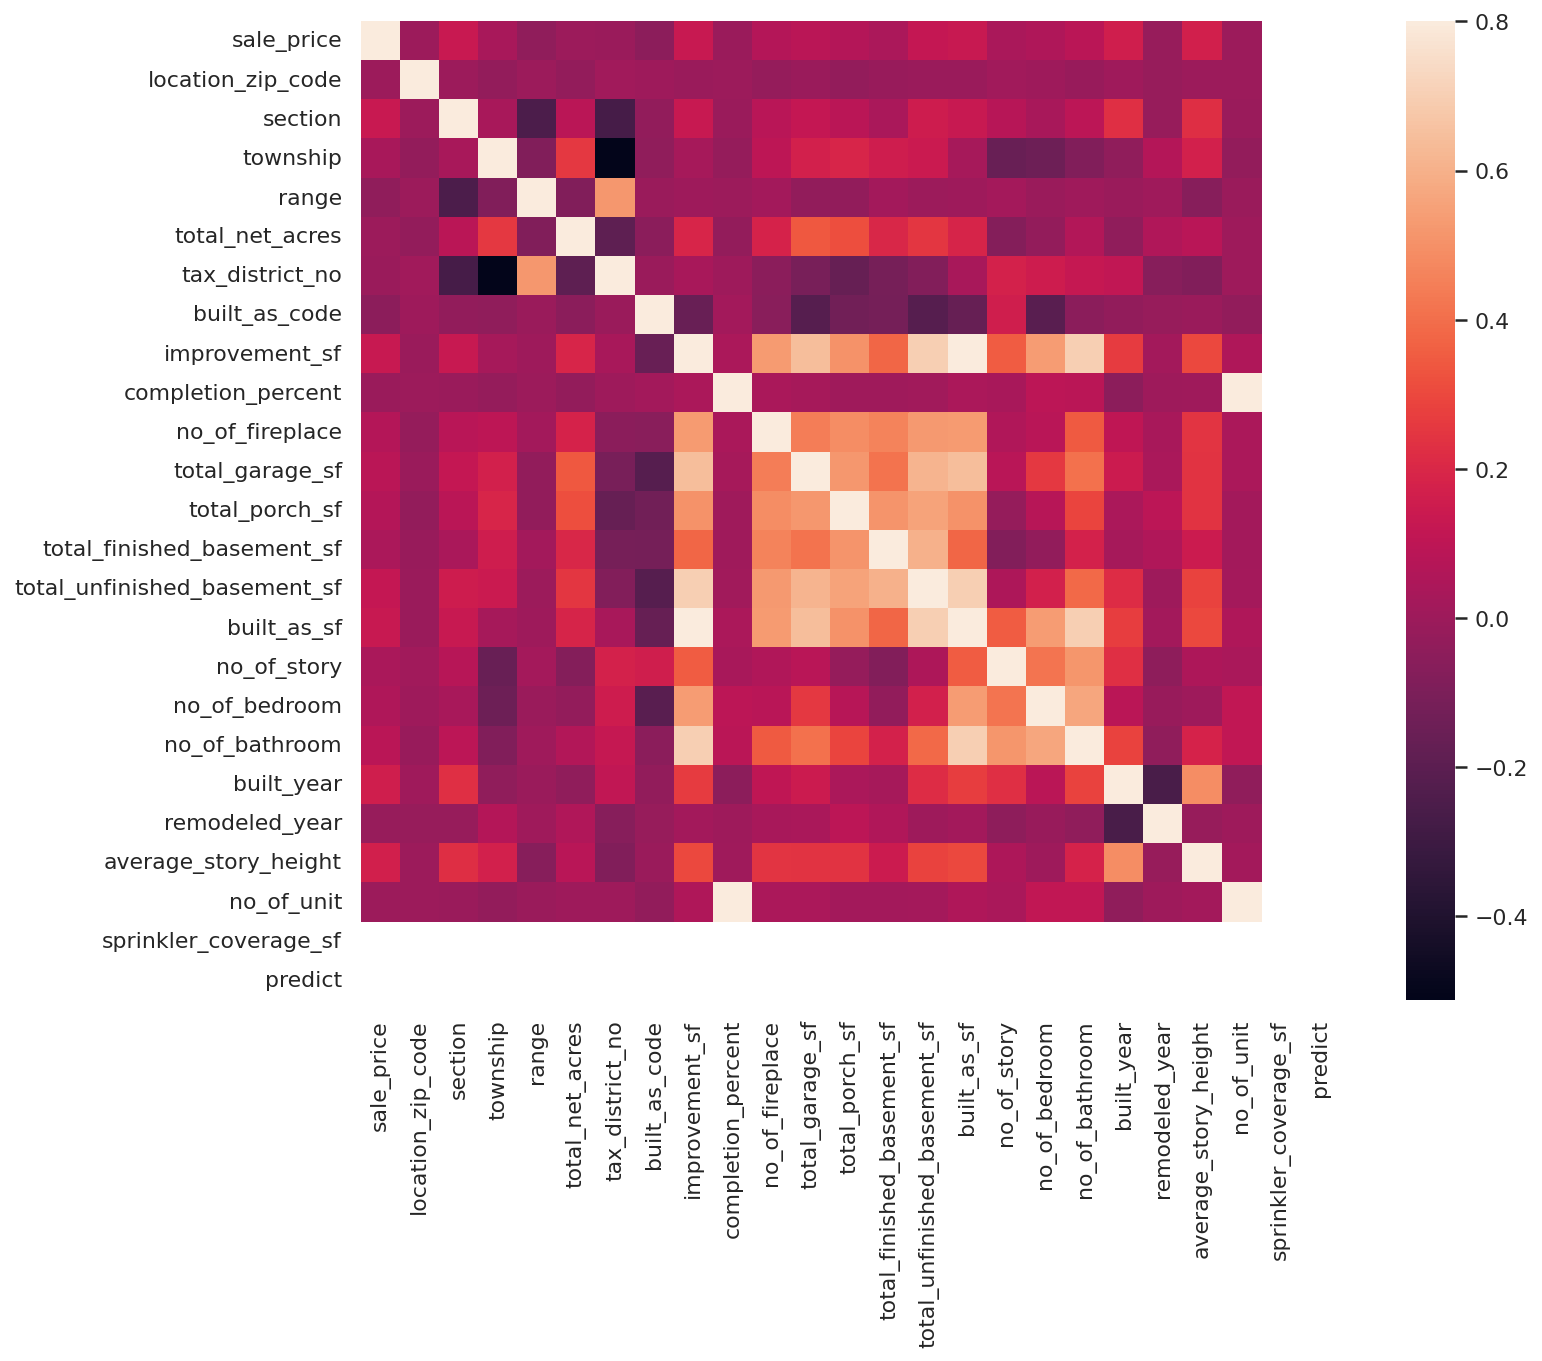

In [ ]:
# Plot Correlation Matrix Heatmap to see which variables are related
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We notice that variable pairs such as (built_as_sf, improvement_sf), (completion_percent, sprinkler_coverage_sf) are highly correlated. So we can reserve just one variable in the pair since keeping both will be redundant.

In [ ]:
# Drop the useless columns of training set & test set
train.drop(train.columns[[0,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,22,24,25,28,29,30,31,37,39,40,42,43,49,50,52,53]], axis = 1, inplace = True)
test.drop(test.columns[[0,3,4,5,6,7,8,11,12,13,14,15,16,18,19,20,21,22,24,25,28,29,30,31,37,39,40,42,43,49,50,52,53,54]], axis = 1, inplace = True)
col_list = train.transaction_date.values.tolist()

# Extract transaction year and transaction month from transaction date, so that year and month information can be used inthe model
year_list = [int(x[-4:]) for x in col_list]
month_list = [str(x[-7:-4]) for x in col_list]
train['transaction_year'] = year_list
train['transaction_month'] = month_list
col_list = test.transaction_date.values.tolist()
year_list = [int(x[-4:]) for x in col_list]
month_list = [str(x[-7:-4]) for x in col_list]
test['transaction_year'] = year_list
test['transaction_month'] = month_list
train.drop('transaction_date', axis = 1, inplace = True)
test.drop('transaction_date', axis = 1, inplace = True)


In [ ]:
train.head()

,sale_price,location_zip_code,city_name,total_net_acres,style,quality_code,property_type_code,total_garage_sf,walkout_basement_flag,total_porch_sf,...,built_as_sf,no_of_story,no_of_bedroom,no_of_bathroom,built_year,remodeled_year,average_story_height,condition,transaction_year,transaction_month
0,62000.0,80125,LITTLETON,0.230,Single Family Residential,Average,Residential,379,N,388.0,...,1080,1.0,3,1.0,1947,1960.0,8.0,Average,1983,feb
1,67200.0,80125,LITTLETON,0.230,Single Family Residential,Average,Residential,379,N,388.0,...,1080,1.0,3,1.0,1947,1960.0,8.0,Average,1985,sep
2,37500.0,80125,LITTLETON,0.230,Single Family Residential,Average,Residential,379,N,388.0,...,1080,1.0,3,1.0,1947,1960.0,8.0,Average,1991,may
3,84000.0,80131,LOUVIERS,0.143,Single Family Residential,Average,Residential,507,N,456.0,...,1691,1.0,3,2.0,1957,1965.0,8.0,Average,1993,apr
4,81000.0,80125,LITTLETON,0.359,Single Family Residential,Average,Residential,892,N,249.0,...,1405,1.0,2,1.0,1950,1960.0,8.0,Average,1986,sep


In [ ]:
test.head()

,sale_price,location_zip_code,city_name,total_net_acres,style,quality_code,property_type_code,total_garage_sf,walkout_basement_flag,total_porch_sf,...,built_as_sf,no_of_story,no_of_bedroom,no_of_bathroom,built_year,remodeled_year,average_story_height,condition,transaction_year,transaction_month
0,375000,80125,LITTLETON,0.434,Single Family Residential,Good,Residential,861,N,207,...,3292,1,4,3,1989,0,10,Good,2012,dec
1,590000,80118,LARKSPUR,0.940,Single Family Residential,Very Good,Residential,667,N,646,...,4994,2,4,5,2008,0,11,Good,2012,dec
2,250000,80104,CASTLE ROCK,0.516,Single Family Residential,Average,Residential,576,N,81,...,1330,1,2,1,1958,1990,8,Average,2012,dec
3,190000,80104,CASTLE ROCK,0.265,Single Family Residential,Good,Residential,308,N,301,...,1092,1,3,2,1965,0,8,Average,2012,dec
4,520000,80138,PARKER,2.882,Single Family Residential,Good,Residential,784,N,2402,...,4174,1,4,4,1972,0,8,Average,2012,dec


In [ ]:
# Checking Categorical Data
train.select_dtypes(include=['object']).columns

Index(['city_name', 'style', 'quality_code', 'property_type_code',
       'walkout_basement_flag', 'condition', 'transaction_month'],
      dtype='object')

In [ ]:
# Checking Numerical Data
train.select_dtypes(include=['int64','float64']).columns

Index(['sale_price', 'location_zip_code', 'total_net_acres', 'total_garage_sf',
       'total_porch_sf', 'total_finished_basement_sf',
       'total_unfinished_basement_sf', 'built_as_sf', 'no_of_story',
       'no_of_bedroom', 'no_of_bathroom', 'built_year', 'remodeled_year',
       'average_story_height', 'transaction_year'],
      dtype='object')

In [ ]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  7 categorical + 15 numerical = 22 features


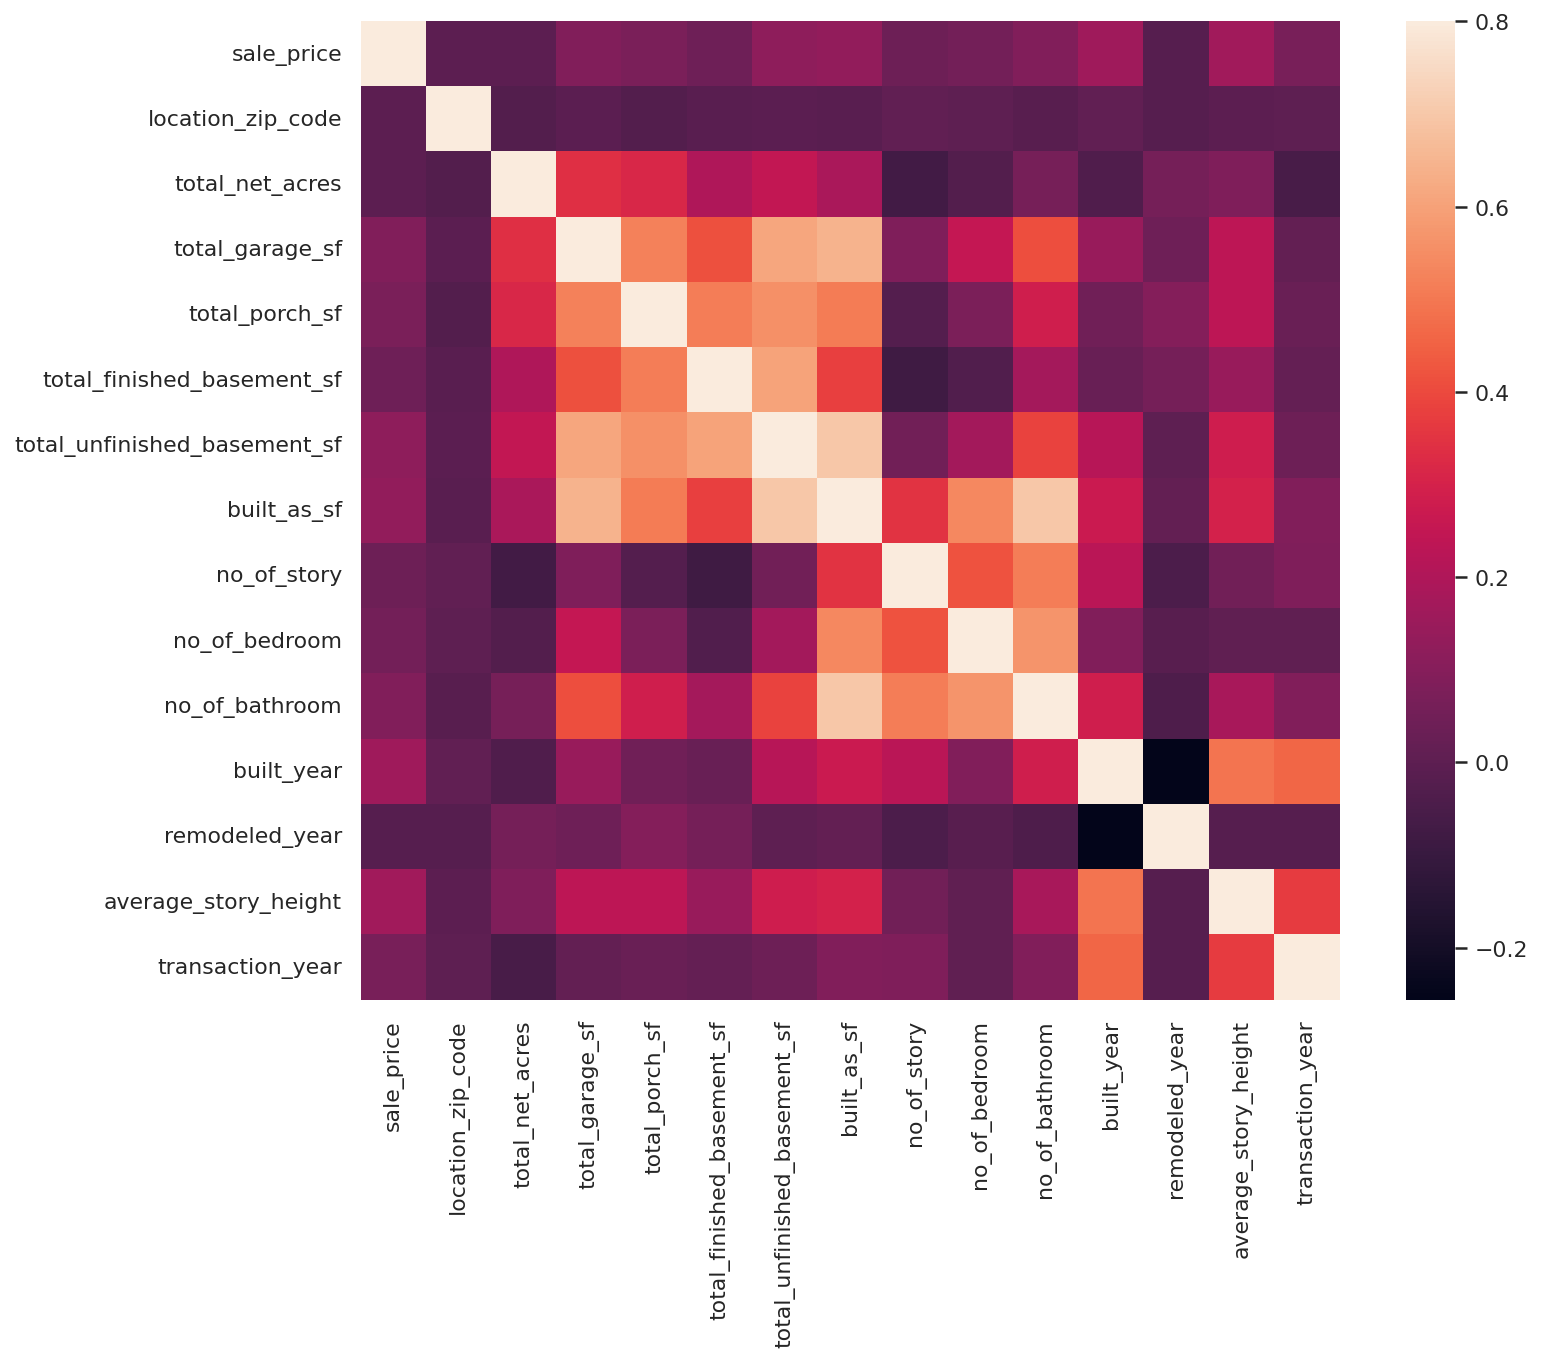

In [ ]:
# Correlation Matrix Heatmap for the remaining variables.
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We don't have highly related variables now after reducing redundance.

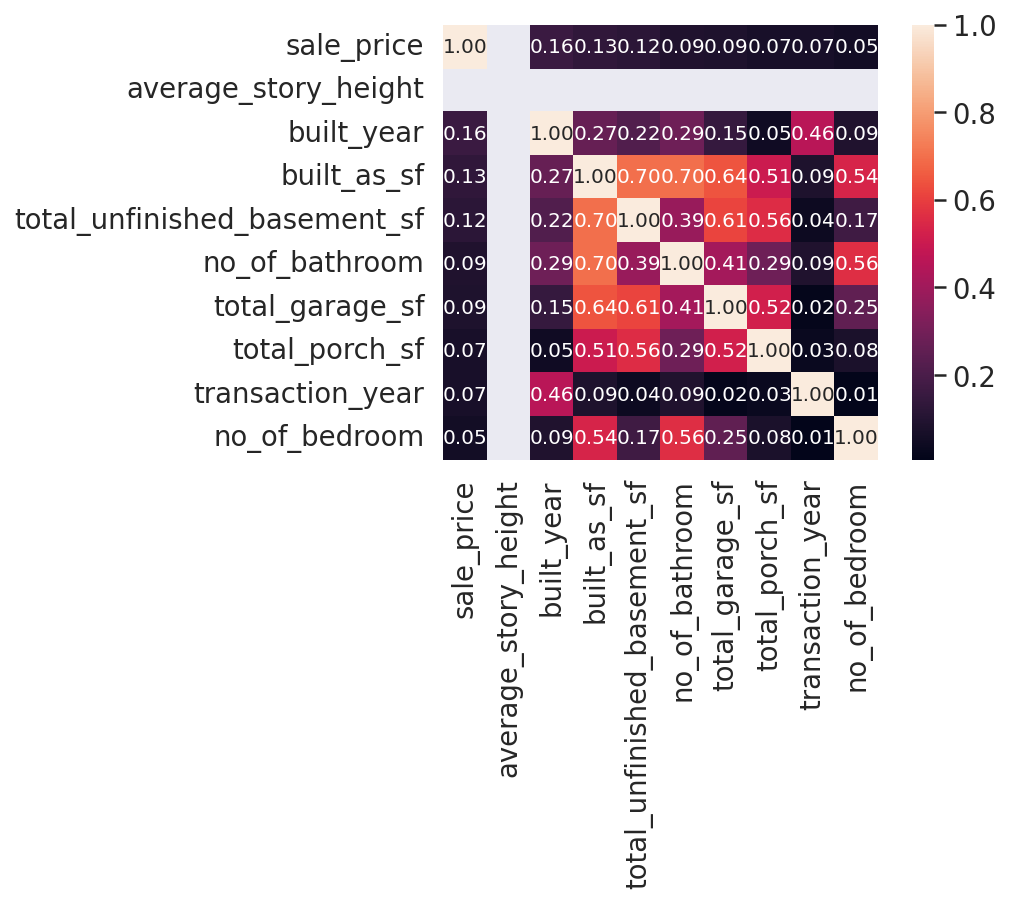

In [ ]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sale_price')['sale_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
initial_train = train
initial_train.shape

(210089, 22)

We plot the heat map for the top ten variables correlated to sale_price. These variables are likely to have a large weight compared with other variables in the prediction model, and we want to remove the outliers of these variables in the next step.

# Remove Outlier

### Remove outlier of 'built_as_sf'

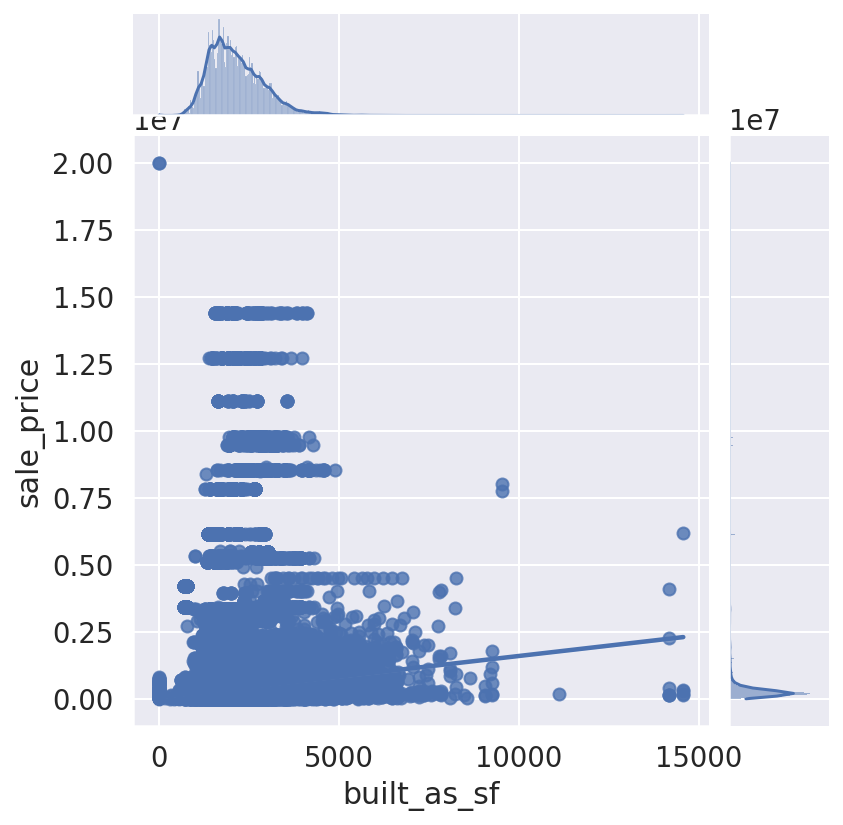

In [ ]:
sns.jointplot(x=train['built_as_sf'], y=train['sale_price'], kind='reg')

### Data Selection:
We are not interested in houses that are extremely big (larger than 5000 sqf) or extremely expensive (>2500000 dollar).


We only focus on transactions happening after the year 2000, so drop data before 2000.

### Anomaly Detection:
We notice some anomalous data which has the same sale-price but with different size, so drop them.


Price lower than 10000, or sqf lower than 100 also could also be anomalous.

In [ ]:
train = train.drop(train[(train['transaction_year']<2000) | (train['built_as_sf']>5000) | (train['sale_price']>2500000) | (train['built_as_sf']<100) | (train['sale_price'] < 100000)
| (train['built_as_sf']< 100)].index).reset_index(drop=True)

In [ ]:
train['transaction_year'].describe()

count    90515.000000
mean      2004.883787
std          3.550392
min       2000.000000
25%       2002.000000
50%       2005.000000
75%       2007.000000
max       2012.000000
Name: transaction_year, dtype: float64

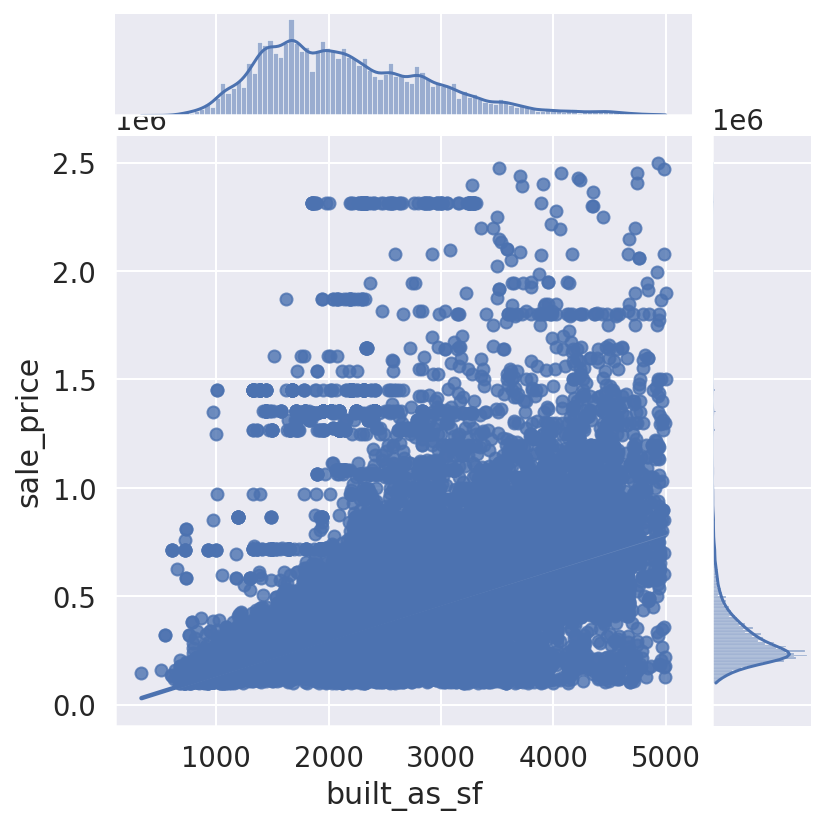

In [ ]:
sns.jointplot(x=train['built_as_sf'], y=train['sale_price'], kind='reg')

### Remove outlier of 'no_of_bathroom'

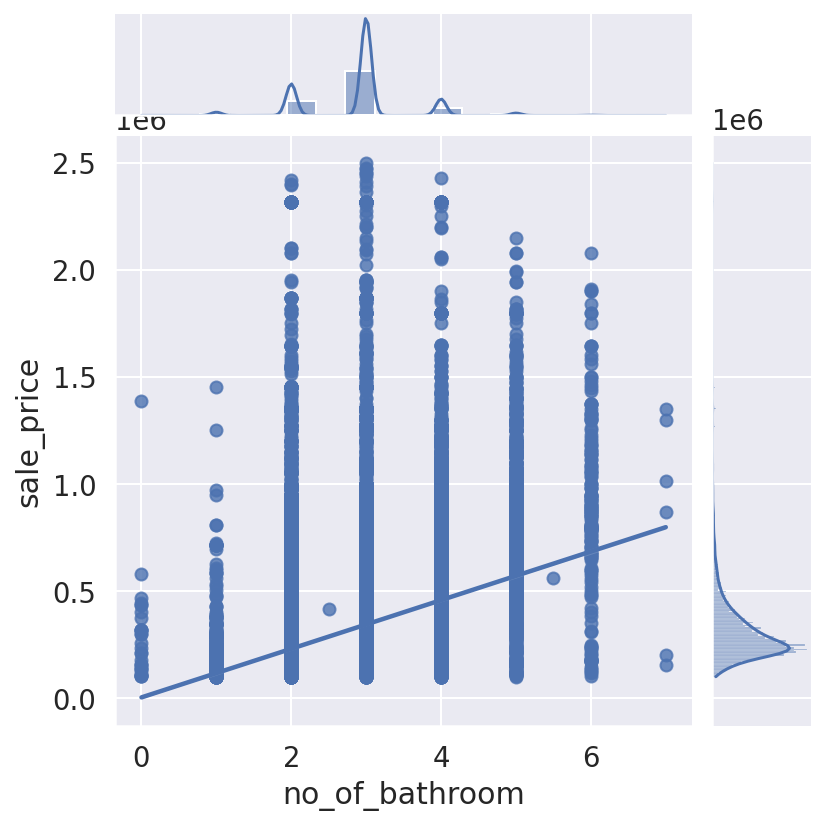

In [ ]:
sns.jointplot(x=train['no_of_bathroom'], y=train['sale_price'], kind='reg')

This looks good, so no operations here.

In [ ]:
train.shape

(90515, 22)

After removing anomalous data and data we don't care, we have about 90,000 data

# Combine dataset and fill missing values

## Combining Datasets

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.sale_price.values
y_test = test.sale_price.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['sale_price'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (90515, 22)
Test data size is : (191, 22)
Combined dataset size is : (90706, 21)


## Find Missing Ratio of Dataset

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
remodeled_year,0.026459
quality_code,0.020947
condition,0.020947


So there are missing data we need to fill in column `remodeled_year`, `quality_code` and `condition`.


Fill missing data in `remodeled year` with 0, since there are a lot of 0 in the non-missing data, possibily meaning that there is no remodeling for the house. We want the missing data to have the same meaning.


Fill missing data in `quality code` and `condition` with average data, since that is most likely the case.

In [ ]:
all_data["remodeled_year"] = all_data["remodeled_year"].fillna(0)
all_data["quality_code"] = all_data["quality_code"].fillna(all_data["quality_code"].mode()[0])
all_data["condition"] = all_data["condition"].fillna(all_data["condition"].mode()[0])

In [ ]:
# Check if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


No missing data now! Then we want to observe the heatmap again after doing data cleaning.

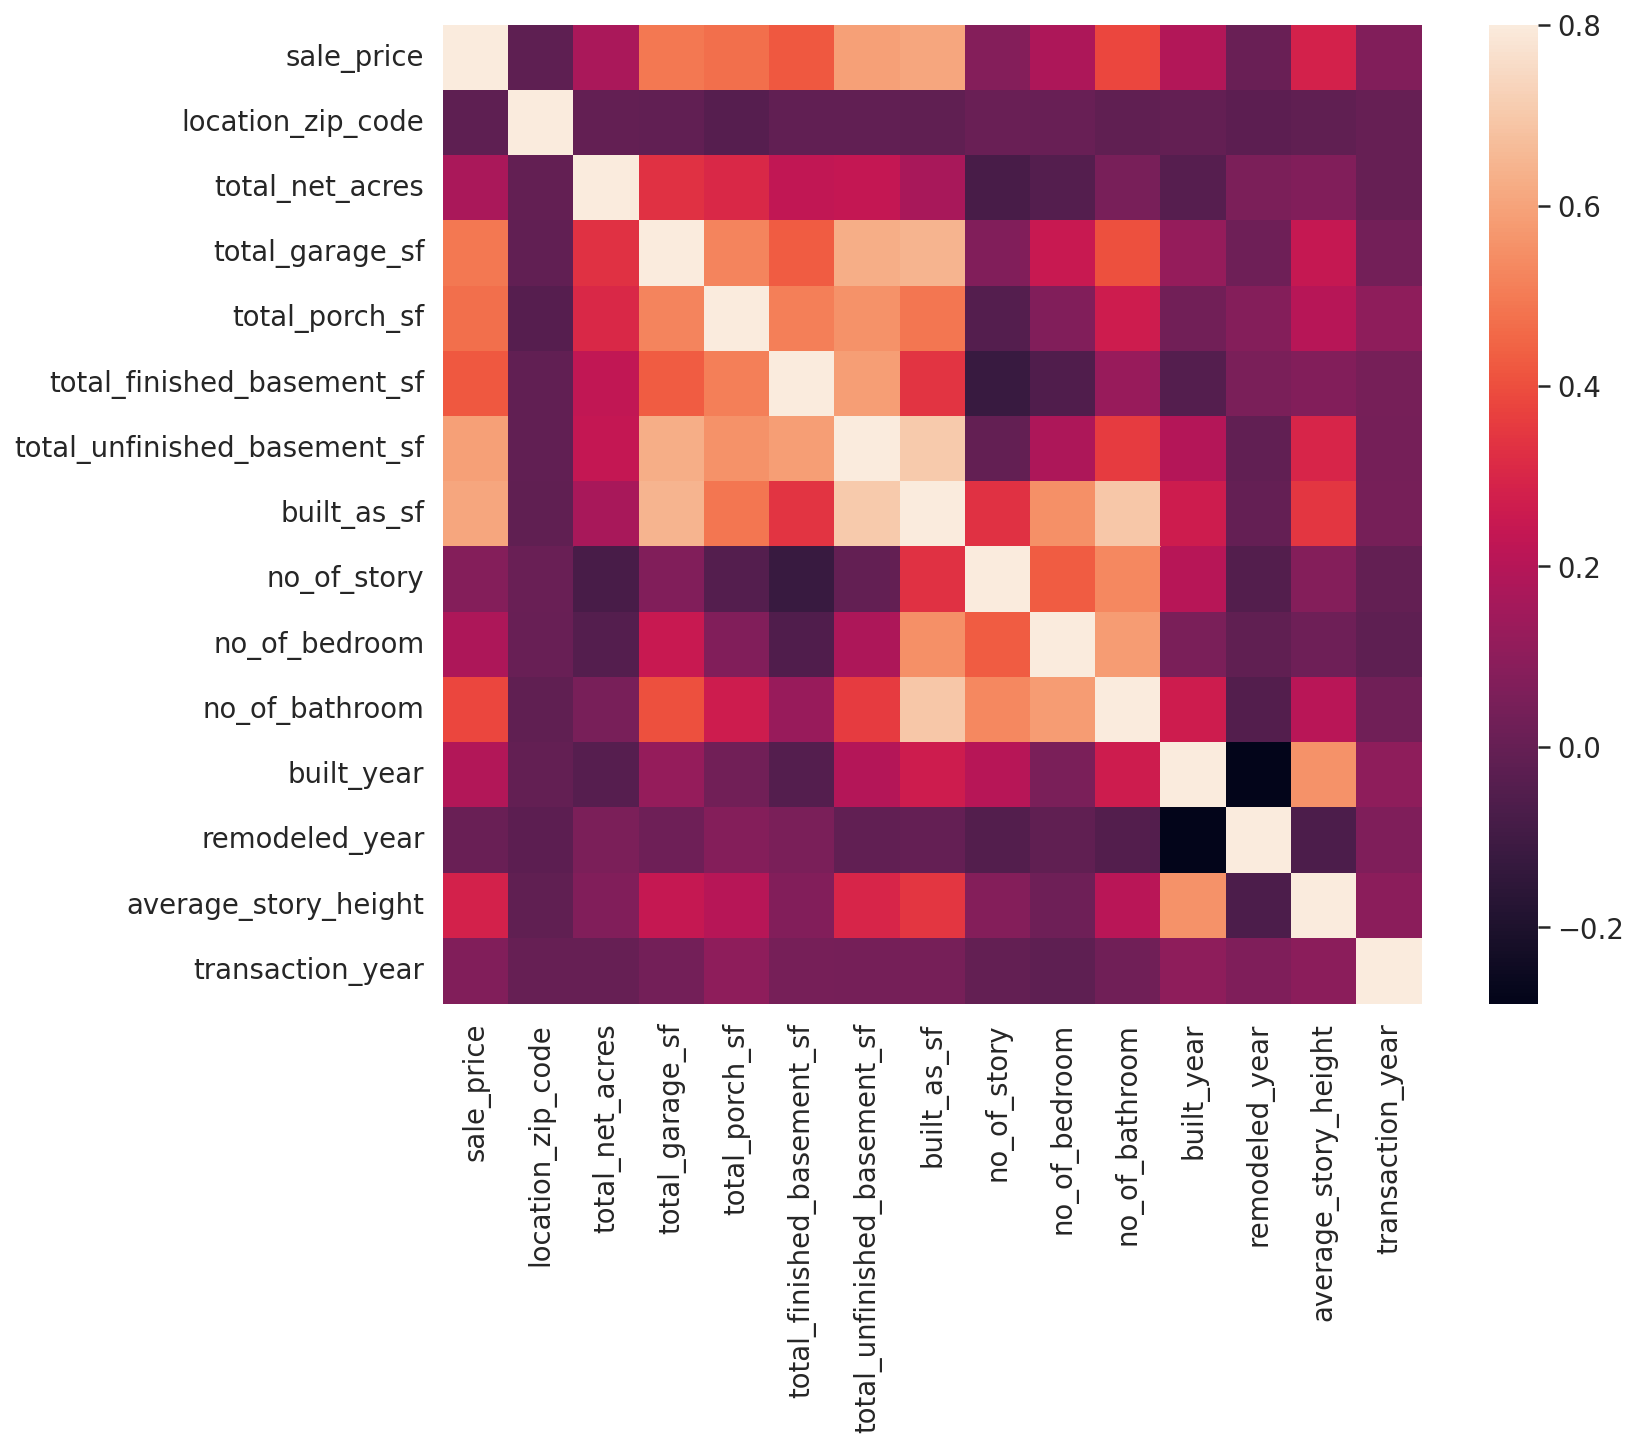

In [ ]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

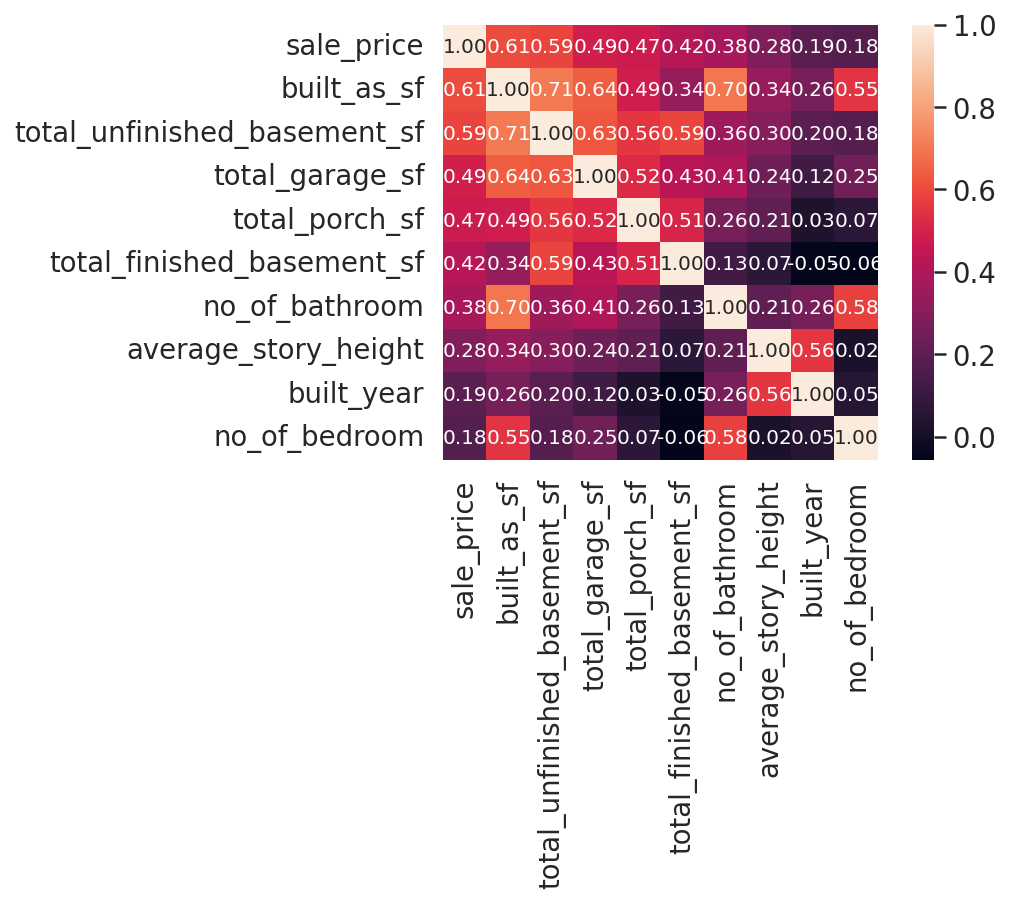

In [ ]:
# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sale_price')['sale_price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We find the correlation between sale price and other attributes are increased, indicating that the data becomes less noisy.

#  Feature Transformation/Engineering

## Transform categorical features to numerial or vice versa

`location_zip_code` was interpreted as numerical when it is actually categorical, so transform it to a category type.

In [ ]:
all_data['location_zip_code'] = all_data['location_zip_code'].apply(str)

`quality_code` and `condition` was interpreted as categorical but is can actually be numerical, so encode them!

Creating a map between `quality_code` / `condition` and a integer score makes sense.

In [ ]:
# replace 'quality code' with number
all_data = all_data.replace({'quality_code': {'Low': 0, 'Fair': 1, 'Average':2, 'Good':3, "Very Good":4, "Excellent":5}})

In [ ]:
all_data.quality_code.describe()

count    90706.000000
mean         2.391077
std          0.642678
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: quality_code, dtype: float64

In [ ]:
# replace 'condition' with number
all_data = all_data.replace({'condition': {'Badly Worn': 0, 'Worn Out': 1, 'Average':2, 'Good':3, "Very Good":4}})

In [ ]:
all_data.condition.describe()

count    90706.000000
mean         2.875069
std          0.334224
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: condition, dtype: float64

# Transform sale price

In [ ]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["sale_price"] = np.log1p(train["sale_price"])
y_train = train.sale_price.values

In [ ]:
# Do the same thing for test set
test["sale_price"] = np.log1p(test["sale_price"])
y_test = test.sale_price.values

In [ ]:
all_data1 = pd.get_dummies(all_data)
print(all_data1.shape)

(90706, 72)


In [ ]:
train = all_data1[:ntrain]
test = all_data1[ntrain:]

In [ ]:
print(train.shape)

(90515, 72)


In [ ]:
print(test.shape)

(191, 72)


In [ ]:
print(y_train.size)

90515


In [ ]:
print(y_test.size)

191


The size mathes between features and label, so feed them to the model.

# Modeling and Predictions

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import  r2_score, mean_squared_error
import xgboost as xgb
import lightgbm as lgb


## K-folds cross-validator
Split dataset into 5 consecutive folds. Each fold is used once as a validation set while the 4 remaining folds form the training set.

In [ ]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Models: Lasso Regression, Extreme Gradient Boosting(XGBoost) and Random Forest

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0,
                             learning_rate=0.05, max_depth=6,
                             min_child_weight=1.5, n_estimators=1000,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_forest = RandomForestRegressor(n_estimators=1000,
                                   max_depth=6, max_features='auto', random_state =5)

In [ ]:
score = rmsle_cv(lasso)
print("Lasso rmse: {:.4f} \n".format(score.mean()))

Lasso rmse: 0.2620 



In [ ]:
score = rmsle_cv(model_forest)
print("Random Forest rmse: {:.4f} \n".format(score.mean()))

Random Forest rmse: 0.2597 



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost rmse: {:.4f} \n".format(score.mean()))

Xgboost rmse: 0.2292 



## Predict on test set

In [ ]:
import math
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def r_score(y,y_pred):
    return math.sqrt(r2_score(y, y_pred))

In [ ]:
lasso.fit(train, y_train)
lasso_pred = lasso.predict(test)
rmse = rmsle(y_test, lasso_pred)
r = r_score(y_test, lasso_pred)
print("lasso rmse on test set: {:.4f} \n".format(rmse.mean()))
print("lasso r_score on test set: {:.4f} \n".format(r))

lasso rmse on test set: 0.2927 

lasso r_score on test set: 0.7940 



In [ ]:
model_xgb.fit(train, y_train)
xgb_pred = model_xgb.predict(test)
rmse = rmsle(y_test, xgb_pred)
r = r_score(y_test, xgb_pred)
print("XGBoost rmse on test set: {:.4f} \n".format(rmse.mean()))
print("XGBoost r_score on test set: {:.4f} \n".format(r))

XGBoost rmse on test set: 0.2762 

XGBoost r_score on test set: 0.8191 



In [ ]:
model_forest.fit(train, y_train)
forest_pred = model_forest.predict(test)
rmse = rmsle(y_test, forest_pred)
r = r_score(y_test, forest_pred)
print("Random Forest rmse on test set: {:.4f} \n".format(rmse.mean()))
print("Random Forest r_score on test set: {:.4f} \n".format(r))

The rmse of Lasso, XGBoost and Random Forest are: 0.2927, 0.2762, 0.2860.


The R score of Lasso, XGBoost and Random Forest are: 0.7940, 0.8191, 0.8045.



## Plot importance based on fitted trees.

In [ ]:
xgb.plot_importance(model_xgb,max_num_features = 10)

The top 10 important features chosen by the tree are plotted above.